In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

%load_ext autoreload

### Load modules

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf
from src.utilities.helper_classes import * 
import src.solvers.neuralDDE_with_adjoint_accel_Exp as ndde
import src.bio_eqn_case.bio_eqn_1D_modcall_numpy as bio
from src.bio_eqn_case.Bio_Eqn_1D_Helper_Classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import scipy.interpolate
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from shutil import move
import pickle

print(tf.__version__) 

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

2.6.0-dev20210501


## Define some useful classes

### Class for user-defined arguments

In [4]:
class bio_eq_nDDE_args(ndde.arguments, bio.bio_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1.1, rnn_nmax = 3, rnn_dt = 0.5, adj_data_size = 2,
                 model_dir = 'Bio1D_nDistDDE_testcase_v2/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 365.*2, nt = 365*2, nz = 50, z_max = -100, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, 
                 K_u = 1., Psi = 1.46, Xi = 0.1, R_m = 1.5, Lambda = 0.06, gamma = 0.3, Tau = 0.145, 
                 Phi = 0.175, Omega = 0.041, T_bio_min = 10., T_bio_max = 30., wp = 0.65, wd = 8.0, 
                 K_zb = 0.0864, K_z0 = 100.*0.0864, gamma_K = 0.1, T_mld = 365, bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD', isplot = True,
                 ode_alg_name = 'dopri5', nsteps = 1, is_tstart_zero = True): # add more arguments as needed
        
        if bio_model_low_complex == 'NPZ': state_dim = 3*nz
        elif bio_model_low_complex == 'NPZD': state_dim = 4*nz
        elif bio_model_low_complex == 'NNPZD': state_dim = 5*nz

        ndde.arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, rnn_nmax = rnn_nmax, 
                           rnn_dt = rnn_dt, state_dim = state_dim, adj_data_size = state_dim, model_dir = model_dir, restart = restart, val_percentage = val_percentage, isplot = isplot, is_tstart_zero = is_tstart_zero)

        bio.bio_eqn_args.__init__(self, T = T, nt = nt, nz = nz, z_max = z_max, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio_min = T_bio_min, T_bio_max = T_bio_max,
                                  wp = wp, wd = wd, bio_model = bio_model_low_complex, K_zb = K_zb, K_z0 = K_z0, gamma_K = gamma_K, T_mld = T_mld)
        
        self.bio_args_for_high_complex = bio.bio_eqn_args(T = T, nt = nt, nz = nz, z_max = z_max, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio_min = T_bio_min, T_bio_max = T_bio_max,
                                  wp = wp, wd = wd, bio_model = bio_model_high_complex)
        
        self.bio_model_low_complex = bio_model_low_complex
        self.bio_model_high_complex = bio_model_high_complex
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps

In [5]:
args = bio_eq_nDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 8, epochs = 350, learning_rate = 0.05, 
                        decay_rate = 0.97, test_freq = 1, plot_freq = 1, d_max = 5., rnn_nmax = 4+1, rnn_dt = 0.5, 
                        model_dir = 'Bio1D_nDDE_testcase_v3/model_dir_test', restart = 0, val_percentage = 1.,
                        T = 182, nt = 182*10, nz = 20, z_max = -100, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, 
                        K_u = 1., Psi = 1.46, Xi = 0.1, R_m = 1.5, Lambda = 0.06, gamma = 0.3, Tau = 0.145, 
                        Phi = 0.175, Omega = 0.041, T_bio_min = 10., T_bio_max = 30., wp = 0*0.65, wd = 0*8.0, 
                        K_zb = 0.0864, K_z0 = 100.*0.0864, gamma_K = 0.1, T_mld = 365, bio_model_low_complex = 'NPZ', 
                        bio_model_high_complex = 'NNPZD', isplot = True, ode_alg_name = 'dopri5', nsteps = 5, 
                        is_tstart_zero = False)

In [6]:
testcase_dir = 'neuralClosureModels/testcases/Bio_Eqn_1D'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir, save_user_inputs=False)

Higher complexity model done!


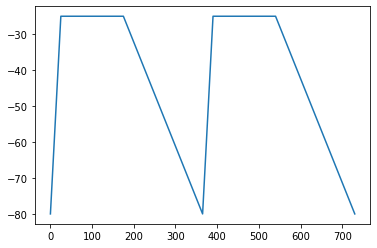

In [7]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup

In [22]:
class custom_plot:

    def __init__(self, z, t, args, K_obj = None):
        self.t = t
        self.args = args
        self.T, self.Z = np.meshgrid(t.numpy(), z.numpy())
        self.z = z
        self.K_obj = K_obj
        
    def plot(self, pred_y, title_start, title_end, max_cbar = None, cmap = cm.coolwarm, t_max=None):
        
        fig = plt.figure(figsize=(30, 5), facecolor='white')
        ax_N = fig.add_subplot(131)
        ax_P = fig.add_subplot(132)
        ax_Z = fig.add_subplot(133)
        
        B_N = tf.transpose(tf.squeeze(pred_y[:, :, 0:self.args.nz], axis=1)).numpy()
        B_P = tf.transpose(tf.squeeze(pred_y[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        B_Z = tf.transpose(tf.squeeze(pred_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy()
        
        if max_cbar == None:
            max_cbar = [np.max(B_N.flatten())]
            max_cbar.append(np.max(B_P.flatten()))
            max_cbar.append(np.max(B_Z.flatten()))
        
        self.plot_indiv(ax_N, title_start + ' N ' + title_end, B_N, max_cbar[0], cmap, t_max)
        self.plot_indiv(ax_P, title_start + ' P ' + title_end, B_P, max_cbar[1], cmap, t_max)
        self.plot_indiv(ax_Z, title_start + ' Z ' + title_end, B_Z, max_cbar[2], cmap, t_max)

        plt.show()
        
    def plot_with_mld(self, pred_y, title_start, title_end, max_cbar = None, cmap = cm.coolwarm, t_max=None):
        
        fig = plt.figure(figsize=(30, 5), facecolor='white')
        ax_N = fig.add_subplot(131)
        ax_P = fig.add_subplot(132)
        ax_Z = fig.add_subplot(133)
        
        B_N = tf.transpose(tf.squeeze(pred_y[:, :, 0:self.args.nz], axis=1)).numpy()
        B_P = tf.transpose(tf.squeeze(pred_y[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        B_Z = tf.transpose(tf.squeeze(pred_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy()
        
        if max_cbar == None:
            max_cbar = [np.max(B_N.flatten())]
            max_cbar.append(np.max(B_P.flatten()))
            max_cbar.append(np.max(B_Z.flatten()))
        
        self.plot_indiv_with_mld(ax_N, title_start + ' N ' + title_end, B_N, max_cbar[0], cmap, t_max)
        self.plot_indiv_with_mld(ax_P, title_start + ' P ' + title_end, B_P, max_cbar[1], cmap, t_max)
        self.plot_indiv_with_mld(ax_Z, title_start + ' Z ' + title_end, B_Z, max_cbar[2], cmap, t_max)

        plt.show()

        
    def plot_indiv(self, ax, title, B, max_cbar_lim, cmap, t_max=None):
        ax.cla()
        ax.set_title(title, fontsize=22)
        ax.set_ylabel('z (m)', fontsize=22)
        ax.set_xlabel('t (days)', fontsize=22)
        plot = ax.contourf(self.T, self.Z, B, cmap=cmap,
                           antialiased=False, levels=np.linspace(0, max_cbar_lim, 40), extend='both')
        ax.set_ylim(self.z[-1], self.z[0])
        if t_max == None:
            ax.set_xlim(self.t[0], self.t[-1])
        else:
            ax.set_xlim(self.t[0], t_max)
        cbar = plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10)
        cbar.ax.tick_params(labelsize=12)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        
    def plot_indiv_with_mld(self, ax, title, B, max_cbar_lim, cmap, t_max=None):
        ax.cla()
        ax.set_title(title, fontsize=22)
        ax.set_ylabel('z (m)', fontsize=22)
        ax.set_xlabel('t (days)', fontsize=22)
        plot = ax.contourf(self.T, self.Z, B, cmap=cmap,
                           antialiased=False, levels=np.linspace(0, max_cbar_lim, 40), extend='both')
        
        
        ax.plot(self.t, self.K_obj.M_intrp(self.t), linewidth=3, color='r', linestyle='--')
        ax.set_ylim(self.z[-1], self.z[0])
        if t_max == None:
            ax.set_xlim(self.t[0], self.t[-1])
        else:
            ax.set_xlim(self.t[0], t_max)
        cbar = plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10)
        cbar.ax.tick_params(labelsize=12)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        
    def plot_solar_intensity(self, t_max=None):
        fig = plt.figure(figsize=(4, 1), facecolor='white')
        ax = fig.add_subplot(111)
        
        f = ax.plot(self.t, self.args.I_0_t(self.t), linewidth=2, color='k')
        if t_max == None:
            ax.set_xlim(self.t[0], self.t[-1])
        else:
            ax.set_xlim(self.t[0], t_max)
        ax.set_title('Solar Radiation', fontsize=11)
        ax.set_ylabel('$I_0$ (W $m^{-2}$)', fontsize=11)
        ax.set_xlabel('t (days)', fontsize=11)
        plt.xticks([*range(0, 400, 100)], fontsize = 9)
        plt.yticks(fontsize = 9)

In [9]:
custom_plot_obj = custom_plot(args.z, tf.concat([t, val_t], axis=0), args, K_z_obj)

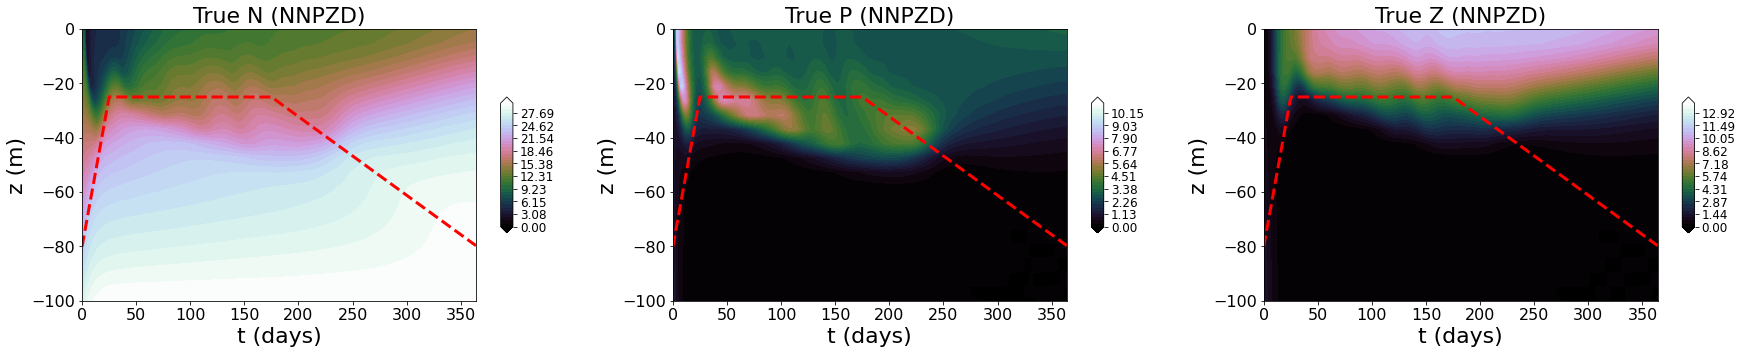

In [10]:
custom_plot_obj.plot_with_mld(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0), 'True', '(NNPZD)', max_cbar = [30., 11., 14.], cmap = cm.cubehelix)

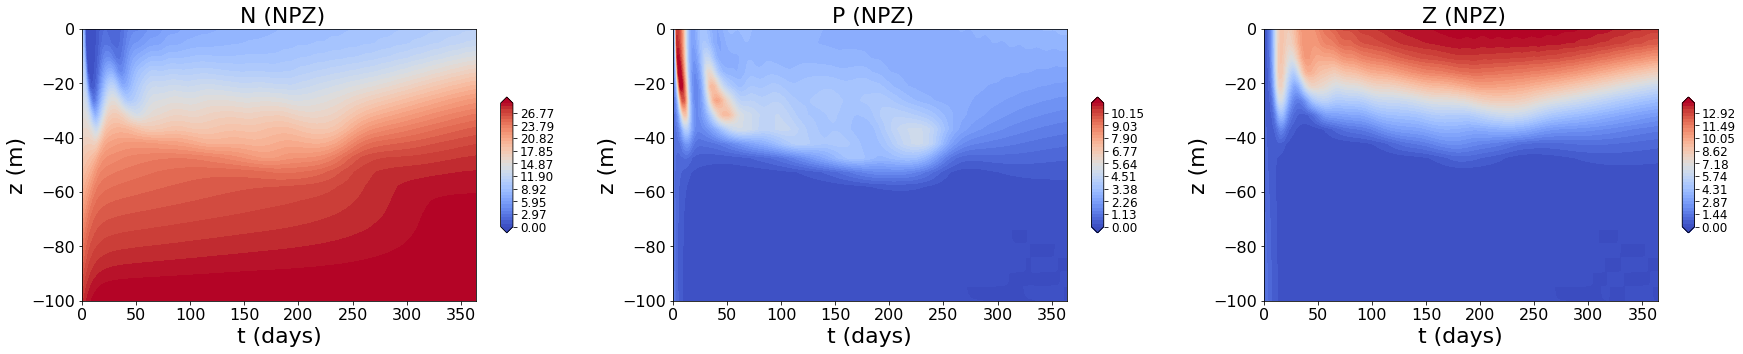

In [11]:
custom_plot_obj.plot(tf.concat([x_low_complex, val_x_low_complex], axis=0), '', '(NPZ)', max_cbar = [29., 11., 14])

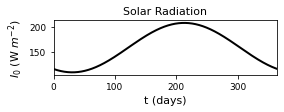

In [12]:
custom_plot_obj.plot_solar_intensity()

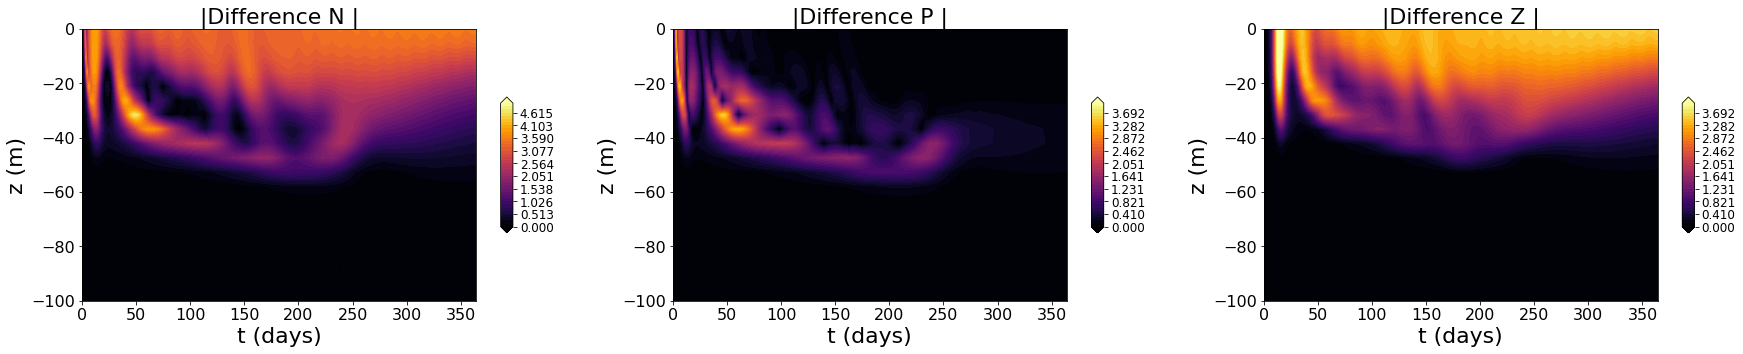

In [13]:
custom_plot_obj.plot(tf.abs(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0) - tf.concat([x_low_complex, val_x_low_complex], axis=0)), '|Difference', '|', max_cbar = [5., 4., 4.], cmap=cm.inferno)

### Compute errors

In [14]:
class compute_error():
    
    def __init__(self, truth, thres = 0.02):
        self.truth = truth
        self.thres = thres
        
    def l2_error(self, pred):
        
        error = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(pred, self.truth), axis=-1)), axis=0)
        
        return error.numpy()
    
    def RMSE(self, pred):
        
        thres = tf.reduce_max(self.truth)*0.02
        error = []
        diff = pred - self.truth
        
        for i in range(1, pred.shape[0]):
            diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
            error_t = diff_t[np.where(diff_t >= thres)]
            if len(error_t) == 0: continue
            error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
            error.append(error_t)

        error = np.mean(np.array(error))
        return error

In [15]:
truth_all = tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0)
pred_y = tf.concat([x_low_complex, val_x_low_complex], axis=0)

In [16]:
truth = truth_all[:, :, 0:args.nz]

err_obj = compute_error(truth)

print('L2 error N: ', np.round(err_obj.l2_error(pred_y[:, :, 0:args.nz]), 3))

print('RMSE error (>2%) N: ', np.round(err_obj.RMSE(pred_y[:, :, 0:args.nz]), 3))

L2 error N:  [7.148]
RMSE error (>2%) N:  2.42


In [17]:
truth = truth_all[:, :, args.nz:2*args.nz]

err_obj = compute_error(truth)

print('L2 error P: ', np.round(err_obj.l2_error(pred_y[:, :, args.nz:2*args.nz]), 3))

print('RMSE error (>2%) P: ', np.round(err_obj.RMSE(pred_y[:, :, args.nz:2*args.nz]), 3))

L2 error P:  [1.937]
RMSE error (>2%) P:  0.791


In [18]:
truth = truth_all[:, :, 2*args.nz:3*args.nz]

err_obj = compute_error(truth)

print('L2 error Z: ', np.round(err_obj.l2_error(pred_y[:, :, 2*args.nz:3*args.nz]), 3))

print('RMSE error (>2%) Z: ', np.round(err_obj.RMSE(pred_y[:, :, 2*args.nz:3*args.nz]), 3))

L2 error Z:  [6.79]
RMSE error (>2%) Z:  2.3


### Just plot training data

In [23]:
custom_plot_obj = custom_plot(args.z, t[0:int(len(t.numpy())*30/182)], args, K_z_obj)

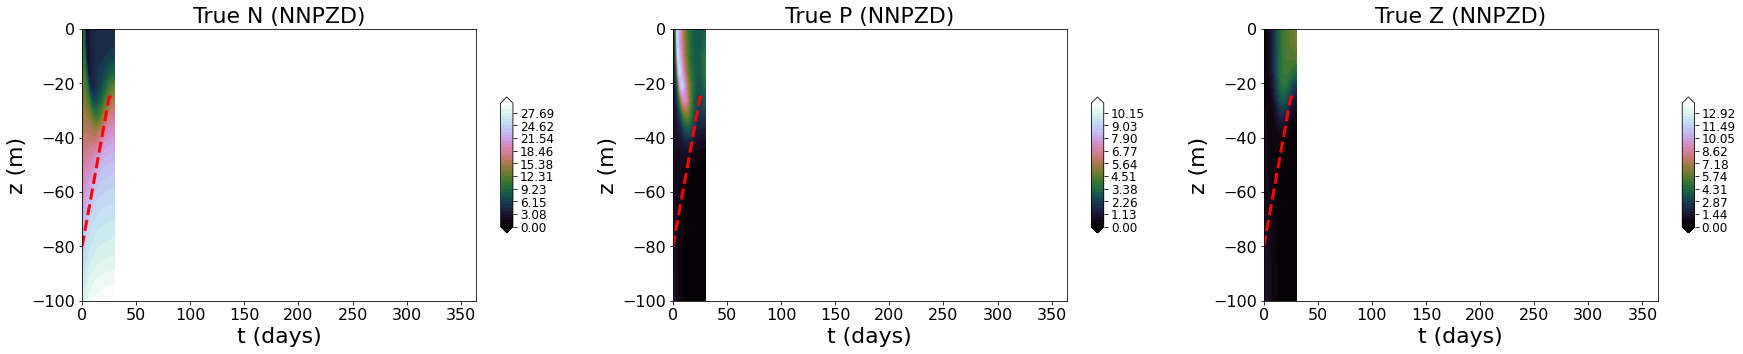

In [24]:
custom_plot_obj.plot_with_mld(true_x_low_complex[0:int(len(t.numpy())*30/182), ], 'True', '(NNPZD)', max_cbar = [30., 11., 14.], cmap = cm.cubehelix, t_max=364)

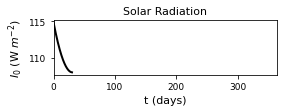

In [25]:
custom_plot_obj.plot_solar_intensity(t_max=364)